# Schelling's Segregation Model

The Nobel prize winning economist Thomas Schelling developed a model that shows  how global patterns of spatial segregation can arise from the effect of *homophily* operating at a local level.

*Homophily* is the principle that we tend to be similar to our friends and/or neighbors.

T. Schelling. Dynamic models of segregation. The Journal of Mathematical Sociology, 1(2), 143-186, 1971.

See also,
* J. M. Sakoda, The checkerboard model of social interaction. The Journalof Mathematical Sociology 1(1), 119-132, 1971.

* R. Hegselmann, Thomas C. Schelling and James M. Sakoda: The intellectual, technical, and social history of a model. Journal of Artificial Societies and Social Simulation 20 (3), 2017.




There are two components of the Schelling model: 

1. A network representing different locations
2. A set of agents with two properties: 
    1. The agent type (e.g., 'red' or 'blue')
    2. The current position of the agent in the network


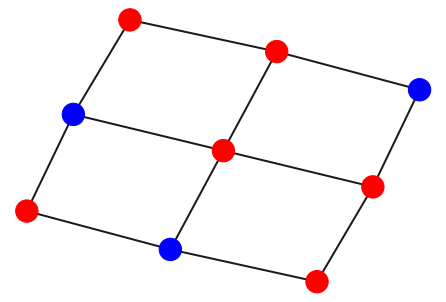

In [90]:
import networkx as nx
import random
import matplotlib.pyplot as plt

grid = nx.grid_2d_graph(3,3)
color_map=list()
for node in grid:
    color_map.append('blue' if random.random() < 0.5 else 'red')
pos = nx.spring_layout(grid, iterations=100)
nx.draw(grid, pos, node_color=color_map, node_size=500, font_color='white', width=2, with_labels=False)
plt.show()

## Dynamics

At each round: 

1. For each agent $a$, determine the number of neighbors that are of the same type. 
2. Agent $a$ is happy if the number of similar agents is above a fixed threshold. 
3. If $a$ is not happy, then $a$  moves to an empty location.

Continue that process for a fixed number of rounds or until every agent is happy. 

## Questions

* How many agents are there? 
* What is the structure of the network? 
* How do you determine the neighbors of an agent? 
* Is the homophily threshold the same for all agents? 
* How densely populated is the network (how many free locations are there)?


## NetLogo Implementation 

[NetLogo Schelling Simulation](http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Social%20Science/Segregation.nlogo)
 

## Implementing Schelling's Model using Python and Mesa

## Mesa 

[https://mesa.readthedocs.io/en/master/](https://mesa.readthedocs.io/en/master/)

In [91]:
from mesa import Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    def __init__(self, pos, agent_type):
        '''
         Create a new Schelling agent.

         Args:
            pos: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        self.pos = pos
        self.type = agent_type
    
    def step(self):
        print("Inside step function. Agent type is ", self.type)

a=SchellingAgent((0,0),1)
print(a)
print(a.type)
print(a.pos)
a.step()

1
(0, 0)
Inside step function. Agent type is  1


In [92]:
a = SchellingAgent((0,0), 1)
b = SchellingAgent((0,1), 0)

print(a)
print(a.pos)
print(a.type)
a.step()

print("\n")
print(b)
print(b.pos)
print(b.type)
b.step()

(0, 0)
1
Inside step function. Agent type is  1


(0, 1)
0
Inside step function. Agent type is  0


In [93]:
from mesa import Model, Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.
         Args:
            pos: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type

    def step(self):
        similar = 0
        neighbors = self.model.grid.neighbor_iter(self.pos)
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar += 1

        # If unhappy, move:
        if similar < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.happy += 1


In [94]:
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''
    def __init__(self, height, width, density, minority_percent, homophily):

        self.height = height
        self.width = width
        self.density = density
        self.minority_percent = minority_percent
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"happy": lambda m: m.happy},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})
        self.running = True
        # Set up agents
        for cell in self.grid.coord_iter():
            #print(cell)
            _,x,y = cell
            if random.random() < self.density:
                if random.random() < self.minority_percent:
                    agent_type = 1
                else:
                    agent_type = 0
                agent = SchellingAgent((x, y), self, agent_type)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        self.happy = 0  # Reset counter of happy agents
        self.schedule.step()
        self.datacollector.collect(self)
        if self.happy == self.schedule.get_agent_count():
            self.running = False


Instatiate a model instance: a 10x10 grid, with an 10% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.

In [95]:
height, width = 10, 10
density = 0.1
minority_percent = 0.2
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)
print("Display the first 5 agents:\n")
for a in model.schedule.agents[0:5]: 
    print(a)
    print("type is ", a.type)
    print(f"pos is {a.pos} \n")


Display the first 5 agents:

type is  0
pos is (6, 3) 

type is  0
pos is (6, 8) 

type is  1
pos is (7, 5) 

type is  0
pos is (2, 4) 

type is  0
pos is (0, 8) 



Instatiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.  Run the model at most 100 times. 

In [96]:
height, width = 50, 50
density = 0.8
minority_percent = 0.3
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)

while model.running and model.schedule.steps < 1000:
    model.step()
print(f"The model ran for {model.schedule.steps} steps") # Show how many steps have actually run

The model ran for 410 steps


The DataCollector object checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [97]:
model_out = model.datacollector.get_model_vars_dataframe()

model_out.head()


,happy
0,1132
1,1401
2,1543
3,1633
4,1669


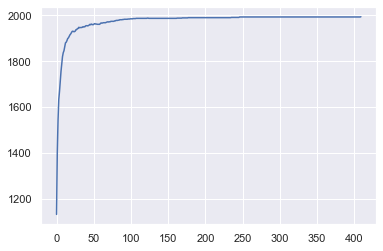

In [98]:
import seaborn as sns
sns.set()
model_out.happy.plot();

## Exploring the Parameter Space

In [99]:
from mesa.batchrunner import BatchRunner

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [100]:
variable_params = {"homophily": range(1,9)}
fixed_params =  {"height": 10, "width": 10, "density": 0.8, "minority_percent": 0.2} 
model_reporters = {"Segregated_Agents": get_segregation}
param_sweep = BatchRunner(SchellingModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=200, 
                          model_reporters=model_reporters, 
                          display_progress=False)

In [101]:
param_sweep.run_all()

In [102]:
df = param_sweep.get_model_vars_dataframe()
df

,homophily,Run,Segregated_Agents,height,width,density,minority_percent
0,1,0,0.395062,10,10,0.8,0.2
1,1,1,0.337500,10,10,0.8,0.2
2,1,2,0.361446,10,10,0.8,0.2
3,1,3,0.385542,10,10,0.8,0.2
4,1,4,0.060976,10,10,0.8,0.2
...,...,...,...,...,...,...,...
75,8,75,0.397590,10,10,0.8,0.2
76,8,76,0.189873,10,10,0.8,0.2
77,8,77,0.240506,10,10,0.8,0.2
78,8,78,0.316456,10,10,0.8,0.2


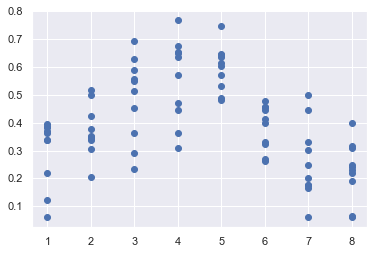

In [103]:
plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)


## Additional Reading


* Brian Hayes, [The Math of Segregation](https://www.americanscientist.org/article/the-math-of-segregation), American Scientist.
  
*   Christina Brandt, Nicole Immorlica, Gautam Kamath, and Robert Kleinberg, [An Analysis of One-Dimensional Schelling Segregation](https://arxiv.org/abs/1203.6346), Proceedings of the forty-fourth annual ACM symposium on theory of computing,  2012. 

* Matthew Jackson, Chapter 5, The Human Network: How Your Social Position Determines Your Power, Beliefs, and Behaviors,  Vintage, 2020.

* David Easley and Jon Kleinberg, Section 4.5, [Networks, Crowds, and Markets: Reasoning about a Highly Connected World](https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch04.pdf), Cambridge University Press, 2010

* [Parable of the Polygons](https://ncase.me/polygons/)